# Анализ лояльности пользователей Яндекс Афиши

## Цель и задачи  

**Цель:** Провести исследовательский анализ данных пользователей Яндекс Афиши с выявлением профиля пользователей, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно.Это позволит:
- Быстро выявлять перспективных клиентов и предлагать им персонализированные условия.
- Точно настраивать рекламу на аудитории с высокой вероятностью возврата.
- Оптимизировать маркетинговые бюджеты.
- Повысить общий уровень удержания клиентов.

**Задачи:**
1. Загрузить данные и познакомиться с их содержимым.
2. Провести предобработку данных.
3. Провести исследовательский анализ данных:
    - изучить данные более детально;
    - изучить взаимосвязь данных.
4. Сформулировать выводы по проведённому анализу.


## Структура проекта

1. Загрузка данных и знакомство с ними.
2. Предобработка данных.
3. Исследовательский анализ данных.
4. Итоговые выводы.

---

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
!pip install phik

# Импортируем библиотеки
import pandas as pd
from sqlalchemy import create_engine

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
from phik import phik_matrix

In [2]:
#данные для подключения к базе данных

db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [3]:
#Строка для подключения:

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
#создаем соединение:
engine = create_engine(connection_string) 

In [5]:
#Запрос:

query = '''
select 
  order_id,
  user_id,
  created_dt_msk as order_dt,
  created_ts_msk as order_ts,
  event_id,
  currency_code,
  device_type_canonical,
  revenue,
  service_name,
  tickets_count,
  event_name_code as event_name,
  event_type_main,
  region_name,
  city_name,
  created_dt_msk::date - LAG(created_dt_msk::date) OVER (PARTITION BY user_id ORDER BY created_dt_msk) as days_since_prev

FROM afisha.purchases p
join afisha.events e using(event_id)
join afisha.city c using(city_id)
join afisha.regions r using(region_id)

WHERE device_type_canonical in ('desktop', 'mobile') AND event_type_main != 'фильм'

ORDER BY user_id
''' 

In [6]:
# Выгружаем данные в переменную clients_df

clients_df = pd.read_sql_query(query, con=engine) 

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [7]:
# Выводим первые строки датафрейма на экран
clients_df.head()

,order_id,user_id,order_dt,order_ts,event_id,currency_code,device_type_canonical,revenue,service_name,tickets_count,event_name,event_type_main,region_name,city_name,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,rub,mobile,1521.94,Край билетов,4,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Каменевский регион,Глиногорск,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,rub,mobile,289.45,Мой билет,2,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Каменевский регион,Глиногорск,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,rub,mobile,1258.57,За билетом!,4,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,Каменевский регион,Глиногорск,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,rub,mobile,8.49,Лови билет!,2,2f638715-8844-466c-b43f-378a627c419f,другое,Североярская область,Озёрск,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,rub,mobile,1390.41,Билеты без проблем,3,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Озернинский край,Родниковецк,83.0


In [8]:
# Выводим информацию о датафрейме
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290611 non-null  int64         
 1   user_id                290611 non-null  object        
 2   order_dt               290611 non-null  datetime64[ns]
 3   order_ts               290611 non-null  datetime64[ns]
 4   event_id               290611 non-null  int64         
 5   currency_code          290611 non-null  object        
 6   device_type_canonical  290611 non-null  object        
 7   revenue                290611 non-null  float64       
 8   service_name           290611 non-null  object        
 9   tickets_count          290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

Датасет `clients_df` содержит 14 столбцов и 290611 строк, в которых представлена информация о клиентах Яндекс Афиши. После первичного анализа данных можно сделать следующие выводы:

- Названия столбцов корректны.
- Типы данных соответствуют содержимому. Тип данных для столбца `tickets_count` можно оптимизировать с понижением размерности. Маловероятно, что он хранит сильно завышенные значения. Столбцы `days_since_prev` и `revenue` также можно оптимизировать с понижением размерности.
- Пропуски есть в столбце `days_since_prev`, но они оправданы. Это означает, что клиент совершил только одну покупку. Также следует проверить в столбцах значения-индикаторы, которые могут говорить об отсутствии данных.
- Значения в столбцах соответствуют описанию.

Первичное знакомство показывает, что данные хорошего качества — в них практически нет пропущенных значений, а сами данные соответствуют описанию и выглядят корректными. Настало время следующего этапа — предобработки данных.

---

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [9]:
#загружаем датафрейм
final_tickets_tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [10]:
print(final_tickets_tenge_df.info())

#необходимо преобразовать столбец с датой к типу datetime для корректного соединения дальше
final_tickets_tenge_df['data'] = pd.to_datetime(final_tickets_tenge_df['data'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB
None


In [11]:
#присоединяем столбец с курсом
clients_df = clients_df.merge(final_tickets_tenge_df[['data', 'curs']], how = 'left', left_on='order_dt', right_on='data')
clients_df = clients_df.drop(columns=['data'])

In [12]:
#напишем функцию для перевода валюты
def convert_func(df):
    if df['currency_code'] == 'kzt':
        df['curs'] = round(df['revenue']/ 100 * df['curs'] , 2)
        return df['curs']
    else:
        return df['revenue']
    
    
clients_df['curs'] = clients_df.apply(convert_func, axis = 1)

In [13]:
#заменим название столбца
clients_df = clients_df.rename(columns = {'curs': 'revenue_rub'})

#для самопроверки
#print(clients_df[clients_df['currency_code']=='kzt'].head())

In [14]:
#Проверим на наличие явных дубликатов

clients_df.duplicated().sum()

0

In [15]:
#Проверим на наличие неявных дубликатов по всем полям, кроме идентификатора заказа и даты

dupl = clients_df.duplicated(['user_id', 'event_id', 'currency_code', 'device_type_canonical', 'revenue', 'service_name', 'tickets_count', 'event_name', 'event_type_main', 'region_name','city_name']).sum()
dupl_perc = dupl/clients_df.shape[0] *100
print(dupl_perc)

22.239350884859828


- Добавлен столбец revenue_rub, который отражает сумму в рублях
- Проведена проверка на явные дубликаты - они не обнаружены
- Проверка на неявные дубликаты по всем полям, кроме идентификатора заказа и даты, показала 22% дублирующих записей. Если избавляться от таких записей, то мы потеряем значительную часть данных. Поэтому предлагаю оставить такие строки, но в будущем выяснить у команды разработки, как работает заполнение таблицы с данными 

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [16]:
#считаем пропуски
print(clients_df.isna().sum())

order_id                     0
user_id                      0
order_dt                     0
order_ts                     0
event_id                     0
currency_code                0
device_type_canonical        0
revenue                      0
service_name                 0
tickets_count                0
event_name                   0
event_type_main              0
region_name                  0
city_name                    0
days_since_prev          21933
revenue_rub                  0
dtype: int64


In [17]:
#понижаем размерность числовых столбцов:
clients_df['tickets_count'] = pd.to_numeric(clients_df['tickets_count'], downcast='integer')
clients_df['revenue'] = pd.to_numeric(clients_df['revenue'], downcast='float')
clients_df['days_since_prev'] = pd.to_numeric(clients_df['days_since_prev'], downcast='float')
clients_df['revenue_rub'] = pd.to_numeric(clients_df['revenue_rub'], downcast='float')

In [18]:
#для самопроверки
print(clients_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290611 non-null  int64         
 1   user_id                290611 non-null  object        
 2   order_dt               290611 non-null  datetime64[ns]
 3   order_ts               290611 non-null  datetime64[ns]
 4   event_id               290611 non-null  int64         
 5   currency_code          290611 non-null  object        
 6   device_type_canonical  290611 non-null  object        
 7   revenue                290611 non-null  float32       
 8   service_name           290611 non-null  object        
 9   tickets_count          290611 non-null  int8          
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

In [19]:
#проверяем столбцы с номинальными данными

for column in ['currency_code', 'device_type_canonical', 'service_name', 'event_type_main', 'region_name', 'city_name']:
    print(f'Уникальные значения в столбце {column}:')
    print(clients_df[column].sort_values().unique())
    print()

Уникальные значения в столбце currency_code:
['kzt' 'rub']

Уникальные значения в столбце device_type_canonical:
['desktop' 'mobile']

Уникальные значения в столбце service_name:
['Crazy ticket!' 'Show_ticket' 'Билет по телефону' 'Билеты без проблем'
 'Билеты в интернете' 'Билеты в руки' 'Быстробилет' 'Быстрый кассир'
 'Весь в билетах' 'Восьмёрка' 'Вперёд!' 'Выступления.ру'
 'Городской дом культуры' 'Дом культуры' 'Дырокол' 'За билетом!'
 'Зе Бест!' 'КарандашРУ' 'Кино билет' 'Край билетов' 'Лимоны'
 'Лови билет!' 'Лучшие билеты' 'Мир касс' 'Мой билет' 'Облачко'
 'Прачечная' 'Радио ticket' 'Реестр' 'Росбилет' 'Тебе билет!' 'Телебилет'
 'Тех билет' 'Цвет и билет' 'Шоу начинается!' 'Яблоко']

Уникальные значения в столбце event_type_main:
['выставки' 'другое' 'концерты' 'спорт' 'стендап' 'театр' 'ёлки']

Уникальные значения в столбце region_name:
['Белоярская область' 'Берестовский округ' 'Берёзовская область'
 'Боровлянский край' 'Верховинская область' 'Верхозёрский край'
 'Верхоречная о

В столбце event_type_main есть категория "другое", которая обозначает, что ни одна из предложенных категорий не подходит, но предлагаю ее оставить

In [20]:
#проверим столбец revenue_rub
revenue_negative = clients_df[clients_df['revenue_rub'] <=0 ]['revenue_rub'].count()
revenue_negative_perc = revenue_negative/clients_df.shape[0] * 100
print(revenue_negative_perc)

2.0326140442034197


Проверили выручку на наличие отрицательных значений - таковых вышло около двух процентов. Соответственно, чтобы не искажать данные предлагаем их удалить

In [21]:
row_count = clients_df.shape[0]

clients_df = clients_df.loc[clients_df['revenue_rub'] > 0]

row_count_after_filter = clients_df.shape[0]
drop_row_count = row_count - row_count_after_filter
drop_row_percent = drop_row_count/row_count
print(f"удалили {drop_row_count} строк, что составляет {drop_row_percent} или {drop_row_percent * 100:.2f}%")

удалили 5907 строк, что составляет 0.020326140442034197 или 2.03%


Проверим распределение выручки

In [22]:
clients_df['revenue_rub'].describe(percentiles=[0.99])

count    284704.000000
mean        567.102234
std         880.828857
min           0.020000
50%         364.279999
99%        2628.419922
max       81174.539062
Name: revenue_rub, dtype: float64

In [23]:
# Проверяем распределение данных по значениям столбца revenue_rub выше 99 процентиля
print('Распределение данных по значениям столбца revenue_rub 99 процентиль и выше:')
clients_df.loc[clients_df['revenue_rub'] >  clients_df['revenue_rub'].quantile(0.99)]['revenue_rub'].value_counts()

Распределение данных по значениям столбца revenue_rub 99 процентиль и выше:


3504.560059    152
2666.800049    106
2742.080078     93
3333.489990     81
2727.100098     48
              ... 
2691.379883      1
5266.419922      1
2715.179932      1
4442.209961      1
2648.850098      1
Name: revenue_rub, Length: 634, dtype: int64

In [24]:
# удалим по 99 процентилю
row_count = clients_df.shape[0]

clients_df = clients_df.loc[clients_df['revenue_rub'] <  clients_df['revenue_rub'].quantile(0.99)]

row_count_after_filter = clients_df.shape[0]
drop_row_count = row_count - row_count_after_filter
drop_row_percent = drop_row_count/row_count
print(f"удалили {drop_row_count} строк, что составляет {drop_row_percent} или {drop_row_percent * 100:.2f}%")

удалили 3007 строк, что составляет 0.01056184668989547 или 1.06%


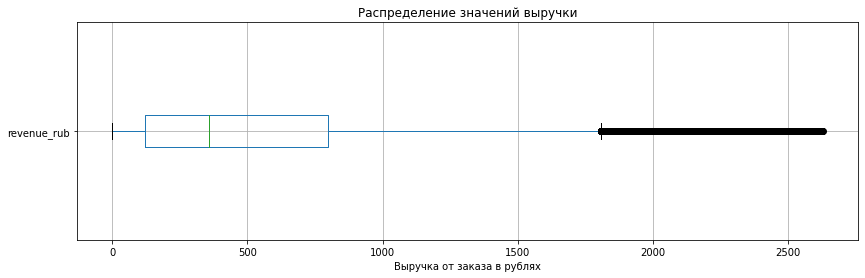

In [25]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(14, 4))

# Строим диаграмму размаха значений в столбце score
clients_df.boxplot(column='revenue_rub', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение значений выручки')
plt.xlabel('Выручка от заказа в рублях')

# Выводим график
plt.show()

Проверим распределение количества билетов

In [26]:
clients_df['tickets_count'].describe(percentiles=[0.99])

count    281697.000000
mean          2.743952
std           1.157546
min           1.000000
50%           3.000000
99%           6.000000
max          47.000000
Name: tickets_count, dtype: float64

Заметно, что 99 процентиль = 6 в то время, как максимальное значение = 47. Значит, в данных встречаются выбросы. Посмотрим на распределение данных:

In [27]:
# Проверяем распределение данных по значениям столбца revenue_rub выше 99 процентиля
print('Распределение данных по значениям столбца revenue_rub 99 процентиль и выше:')
clients_df.loc[clients_df['tickets_count'] >  clients_df['tickets_count'].quantile(0.99)]['tickets_count'].value_counts()

Распределение данных по значениям столбца revenue_rub 99 процентиль и выше:


7     58
9     38
10    19
8     18
11    13
13     7
14     4
17     4
19     4
12     3
15     2
27     2
37     1
47     1
Name: tickets_count, dtype: int64

Отфильтруем по 99 процентилю:

In [28]:
row_count = clients_df.shape[0]

clients_df = clients_df.loc[clients_df['tickets_count'] <  clients_df['tickets_count'].quantile(0.99)]

row_count_after_filter = clients_df.shape[0]
drop_row_count = row_count - row_count_after_filter
drop_row_percent = drop_row_count/row_count
print(f"удалили {drop_row_count} строк, что составляет {drop_row_percent} или {drop_row_percent * 100:.2f}%")

удалили 4094 строк, что составляет 0.014533346113022148 или 1.45%


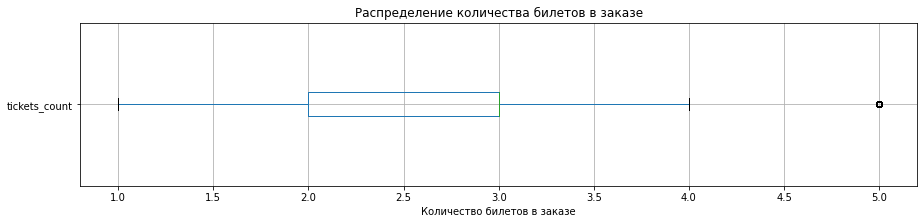

In [29]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 3))

# Строим диаграмму размаха значений в столбце score
clients_df.boxplot(column='tickets_count', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов в заказе')

# Выводим график
plt.show()

В результате предобработки данных были выполнены следующие действия:
- Сумма заказов приведена к единой валюте - был добавлен столбец revenue_rub, который отражает сумму в рублях
- Проведена проверка на явные дубликаты - они не обнаружены. Проверка на неявные дубликаты показала 22%, однако принято решение их оставить
- Понижена размерность числовых столбцов
- Проведена проверка на уникальные значения в столбцах с номинальными данными
- Отфильтрованы значения по столбцу revenue_rub - удалены 3007 строк, что составляет 1.03%
- Удалили около 2% данных, где выручка отрицательна
- Отфильтровали значения по столбцу tickets_count - удалены 4094 строк, что составляет 1.45%

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [30]:
def user_profile(df):
    first_date = df['order_ts'].min()
    last_date = df['order_ts'].max()
    device = df['device_type_canonical'].iloc[0] #переделать
    region = df['region_name'].iloc[0] #переделать
    service_name = df['service_name'].iloc[0] #переделать
    event_type = df['event_type_main'].iloc[0] #переделать
    orders_count = df['order_id'].count()
    revenue_avg = df['revenue'].mean()
    tickets_count_avg = df['tickets_count'].mean()
    days_since_prev_avg = df['days_since_prev'].mean()
    is_two = False
    is_five = False
    if orders_count >= 2:
        is_two = True       
        if orders_count >= 5:
            is_five = True     
    
    return pd.Series({
        'first_date': first_date,
        'last_date': last_date,
        'device': device,
        'region': region,
        'service_name': service_name,
        'event_type': event_type,
        'orders_count': orders_count,
        'revenue_avg': revenue_avg,
        'tickets_count_avg': tickets_count_avg,
        'days_since_prev_avg': days_since_prev_avg,
        'is_two': is_two,
        'is_five': is_five
    })

df = clients_df.sort_values(by = 'order_ts').groupby('user_id').apply(user_profile).reset_index()

In [31]:
# сортируем по времени
clients_df = clients_df.sort_values(by='order_ts')

df = clients_df.groupby('user_id').agg(
    first_date=('order_ts', 'min'),
    last_date=('order_ts', 'max'),
    device=('device_type_canonical', 'first'),
    region=('region_name', 'first'),
    service_name=('service_name', 'first'),
    event_type=('event_type_main', 'first'),
    orders_count=('order_id', 'count'),
    revenue_avg=('revenue', 'mean'),
    tickets_count_avg=('tickets_count', 'mean'),
    days_since_prev_avg=('days_since_prev', 'mean')
).reset_index()

In [32]:
def is_two(df):
    if df['orders_count'] >= 2:
        return True       
    else:
        return False

df['is_two'] = df.apply(is_two, axis = 1)

def is_five(df):
    if df['orders_count'] >= 5:
        return True       
    else:
        return False

df['is_five'] = df.apply(is_five, axis = 1) 

In [33]:
#print(df.columns)
#print(df.info())
#print(df)

In [34]:
#для самопроверки
#print(df)

- Профиль пользователя построен - создан новый датафрейм df для дальнейшней работы

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [35]:
#общее число пользователей в выборке
users_count = df['user_id'].nunique()
print(f"общее число пользователей в выборке: {users_count}")

#среднюю выручку с одного заказа
revenue_avg = round(df['revenue_avg'].mean(), 2)
print(f"средняя выручку с одного заказа: {revenue_avg}")

#долю пользователей, совершивших 2 и более заказа;
is_two = df['is_two'].sum()
is_two_rate = is_two/users_count
print(f"Доля пользователей, совершивших 2 и более заказа: {is_two_rate}, что составляет {is_two_rate * 100:.2f}%")

#долю пользователей, совершивших 5 и более заказов.
is_five = df['is_five'].sum()
is_five_rate = is_five/users_count
print(f"Доля пользователей, совершивших 5 и более заказов: {is_five_rate}, что составляет {is_five_rate * 100:.2f}%")

общее число пользователей в выборке: 21551
средняя выручку с одного заказа: 632.6699829101562
Доля пользователей, совершивших 2 и более заказа: 0.615795090715048, что составляет 61.58%
Доля пользователей, совершивших 5 и более заказов: 0.2878752726091597, что составляет 28.79%


In [36]:
print(df['orders_count'].describe(percentiles=[0.99]))
print(df['tickets_count_avg'].describe(percentiles=[0.99]))
print(df['days_since_prev_avg'].describe(percentiles=[0.99]))

count    21551.000000
mean        12.881212
std        118.143237
min          1.000000
50%          2.000000
99%        149.500000
max       9779.000000
Name: orders_count, dtype: float64
count    21551.000000
mean         2.698722
std          0.853409
min          1.000000
50%          2.700000
99%          5.000000
max          5.000000
Name: tickets_count_avg, dtype: float64
count    13384.000000
mean        15.871225
std         22.332924
min          0.000000
50%          8.000000
99%        112.169998
max        148.000000
Name: days_since_prev_avg, dtype: float64


- Видим заметные выбросы в столбце orders_count (медиана = 2, а среднее = 13, что говорит о правом хвосте). Отфильтруем по 99 процентилю
- В столбце tickets_count_avg отклонений практически нет (медиана сравнима со средним), поэтому отфильтровывать не будем.
- Отметим выбросы в столбце days_since_prev_avg (медиана = 8, а среднее = 16, что говорит о правом хвосте). Однако в этом столбце большой процент пропусков, который влияет на показатели, поэтому фильтровать не будем

In [37]:
print('Распределение данных по значениям столбца orders_count 99 процентиль и выше:')
print(df.loc[df['orders_count'] >  df['orders_count'].quantile(0.99)]['orders_count'].value_counts())
num_rows_above_99 = df[df['orders_count'] > df['orders_count'].quantile(0.99)].shape[0]
print(f" Количество строк, превышающих 99 процентиль: {num_rows_above_99}")

Распределение данных по значениям столбца orders_count 99 процентиль и выше:
156    5
230    3
150    3
500    2
733    2
      ..
475    1
347    1
604    1
233    1
403    1
Name: orders_count, Length: 186, dtype: int64
 Количество строк, превышающих 99 процентиль: 216


In [38]:
#было до удаления
print(f"До удаления было строк: {df.shape[0]}")

#стало после
# Вычисляем 99-й перцентиль
percentile_99_orders_count = df['orders_count'].quantile(0.99)

# Удаляем значения выше этого перцентиля
df = df.loc[df['orders_count'] <= percentile_99_orders_count]
print(f"После удаления стало строк: {df.shape[0]}")
print(f"Удалили строк: {num_rows_above_99}")

До удаления было строк: 21551
После удаления стало строк: 21335
Удалили строк: 216


Проверим выбросы в столбце revenue_avg

In [39]:
df['revenue_avg'].describe(percentiles=[0.99])

count    21335.000000
mean       633.449097
std        785.390137
min          0.070000
50%        481.153992
99%       4080.802070
max      13212.929688
Name: revenue_avg, dtype: float64

Видим, что все еще остались выбросы в столбце revenue_avg. Максимальное значение 13212

In [40]:
# удалим по 99 процентилю revenue_avg
row_count = df.shape[0]

df = df.loc[df['revenue_avg'] <  df['revenue_avg'].quantile(0.99)]

row_count_after_filter = df.shape[0]
drop_row_count = row_count - row_count_after_filter
drop_row_percent = drop_row_count/row_count
print(f"удалили {drop_row_count} строк, что составляет {drop_row_percent} или {drop_row_percent * 100:.2f}%")

удалили 214 строк, что составляет 0.010030466369814858 или 1.00%


In [41]:
df['revenue_avg'].describe(percentiles=[0.99])

count    21121.000000
mean       574.848694
std        490.593414
min          0.070000
50%        476.225006
99%       2354.926074
max       4032.444824
Name: revenue_avg, dtype: float64

In [42]:
#общее число пользователей в выборке
users_count = df['user_id'].nunique()
print(f"общее число пользователей в выборке: {users_count}")

#среднюю выручку с одного заказа
revenue_avg = round(df['revenue_avg'].mean(), 2)
print(f"средняя выручку с одного заказа: {revenue_avg}")

#долю пользователей, совершивших 2 и более заказа;
is_two = df['is_two'].sum()
is_two_rate = is_two/users_count
print(f"Доля пользователей, совершивших 2 и более заказа: {is_two_rate}, что составляет {is_two_rate * 100:.2f}%")

#долю пользователей, совершивших 5 и более заказов.
is_five = df['is_five'].sum()
is_five_rate = is_five/users_count
print(f"Доля пользователей, совершивших 5 и более заказов: {is_five_rate}, что составляет {is_five_rate * 100:.2f}%")

общее число пользователей в выборке: 21121
средняя выручку с одного заказа: 574.8499755859375
Доля пользователей, совершивших 2 и более заказа: 0.6128971166137966, что составляет 61.29%
Доля пользователей, совершивших 5 и более заказов: 0.2822783012167984, что составляет 28.23%


Итоги раздела:

- Построили профиль пользователя
- Посчитали статичтические показатели - общее число пользователей (21121), средняя выручку с одного заказа (574.84), доля пользователей, совершивших 2 и более заказа 61.29%), доля пользователей, совершивших 5 и более заказов 28.23%) 
- Отфильтровали выбросы по 99  процентилю в столбце orders_count (медиана = 2, а среднее = 13, что говорит о правом хвосте). Удалили 216 строк 
- Отфильтровали выбросы по 99  процентилю в столбце revenue_rub. Удалили 214 строк

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [43]:
#по типу их первого мероприятия
event_type_grouped = df.groupby('event_type')['user_id'].count().sort_values().reset_index()
event_type_grouped['rate'] = event_type_grouped['user_id'] / users_count
print(event_type_grouped)

  event_type  user_id      rate
0       ёлки       96  0.004545
1   выставки      417  0.019743
2      спорт      760  0.035983
3    стендап     1102  0.052176
4      театр     4240  0.200748
5     другое     5130  0.242886
6   концерты     9376  0.443918


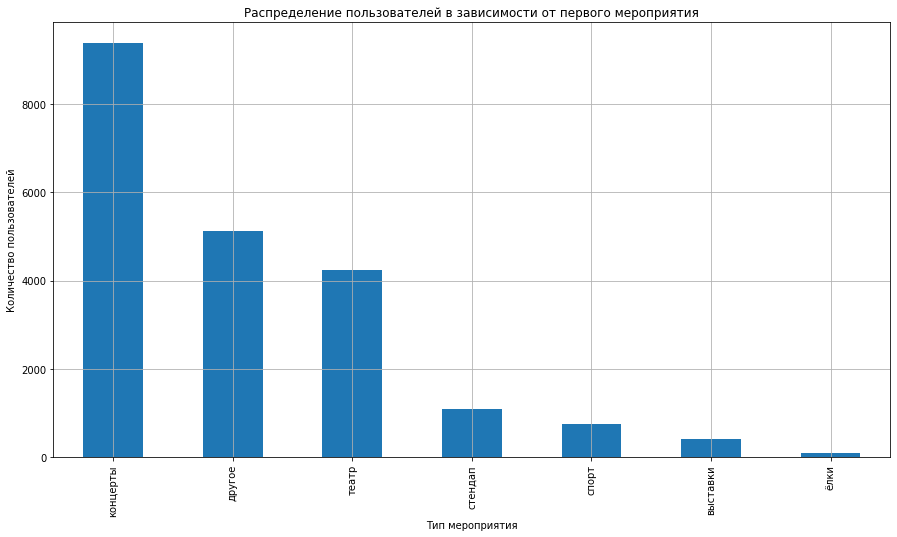

In [44]:
#по типу их первого мероприятия

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 8))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
df['event_type'].value_counts().plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               legend=False, # Выключаем легенду
               title=f'Распределение пользователей в зависимости от первого мероприятия'
)

# Настраиваем оформление графика
plt.xlabel('Тип мероприятия')
plt.ylabel('Количество пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

In [45]:
#по типу устройства, с которого совершена первая покупка
device_grouped = df.groupby('device')['user_id'].count().sort_values().reset_index()
device_grouped['rate'] = device_grouped['user_id'] / users_count
print(device_grouped)

    device  user_id      rate
0  desktop     3596  0.170257
1   mobile    17525  0.829743


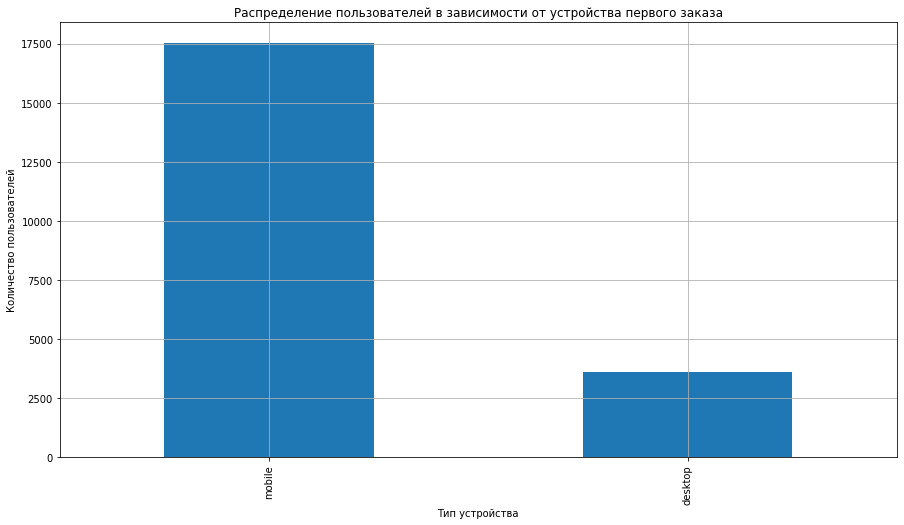

In [46]:
#по типу устройства, с которого совершена первая покупка

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 8))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
df['device'].value_counts().plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               legend=False, # Выключаем легенду
               title=f'Распределение пользователей в зависимости от устройства первого заказа'
)

# Настраиваем оформление графика
plt.xlabel('Тип устройства')
plt.ylabel('Количество пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

In [47]:
#по региону проведения мероприятия из первого заказа
region_grouped = df.groupby('region')['user_id'].count().sort_values().reset_index()
region_grouped['rate'] = region_grouped['user_id'] / users_count
print(region_grouped)

                      region  user_id      rate
0         Яснопольский округ        1  0.000047
1   Сосноводолинская область        1  0.000047
2          Верхозёрский край        1  0.000047
3             Залесский край        2  0.000095
4          Светолесский край        2  0.000095
..                       ...      ...       ...
76      Малиновоярский округ      526  0.024904
77          Озернинский край      672  0.031817
78       Широковская область     1226  0.058046
79      Североярская область     3730  0.176601
80        Каменевский регион     6944  0.328772

[81 rows x 3 columns]


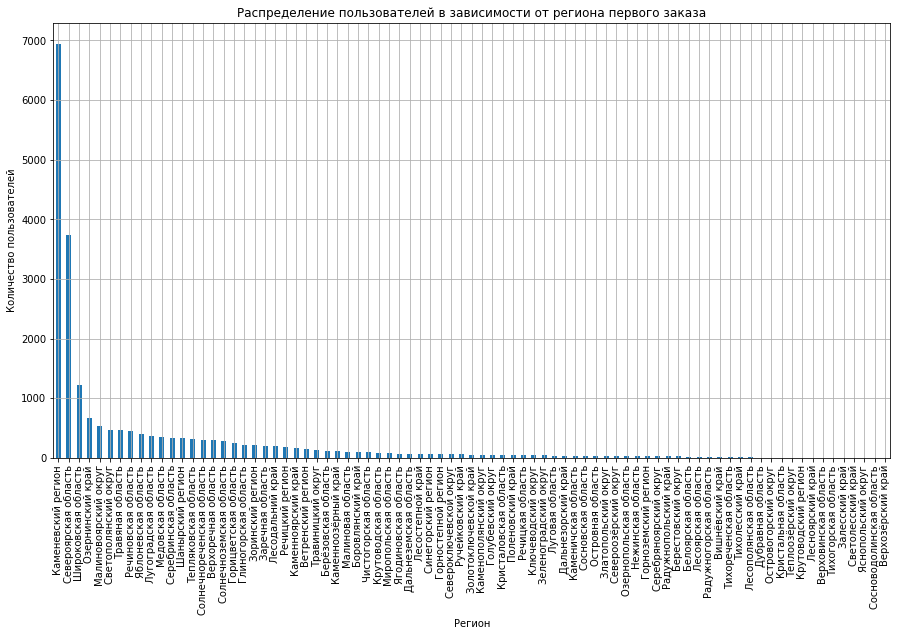

In [48]:
#по региону проведения мероприятия из первого заказа

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 8))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
df['region'].value_counts().plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               #rot=45, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение пользователей в зависимости от региона первого заказа'
)

# Настраиваем оформление графика
plt.xlabel('Регион')
plt.ylabel('Количество пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

In [49]:
#по билетному оператору, продавшему билеты на первый заказ
service_name_grouped = df.groupby('service_name')['user_id'].count().sort_values().reset_index()
service_name_grouped['rate'] = service_name_grouped['user_id'] / users_count
print(service_name_grouped)

              service_name  user_id      rate
0                 Зе Бест!        1  0.000047
1                Тех билет        2  0.000095
2                   Лимоны        2  0.000095
3        Билет по телефону        6  0.000284
4                  Вперёд!        7  0.000331
5               Кино билет        9  0.000426
6             Цвет и билет       15  0.000710
7               КарандашРУ       15  0.000710
8          Шоу начинается!       19  0.000900
9                Телебилет       28  0.001326
10                  Реестр       32  0.001515
11            Радио ticket       36  0.001704
12                Росбилет       40  0.001894
13           Crazy ticket!       45  0.002131
14          Быстрый кассир       60  0.002841
15               Восьмёрка       85  0.004024
16          Выступления.ру       95  0.004498
17             Show_ticket      160  0.007575
18             Быстробилет      162  0.007670
19             За билетом!      200  0.009469
20  Городской дом культуры      21

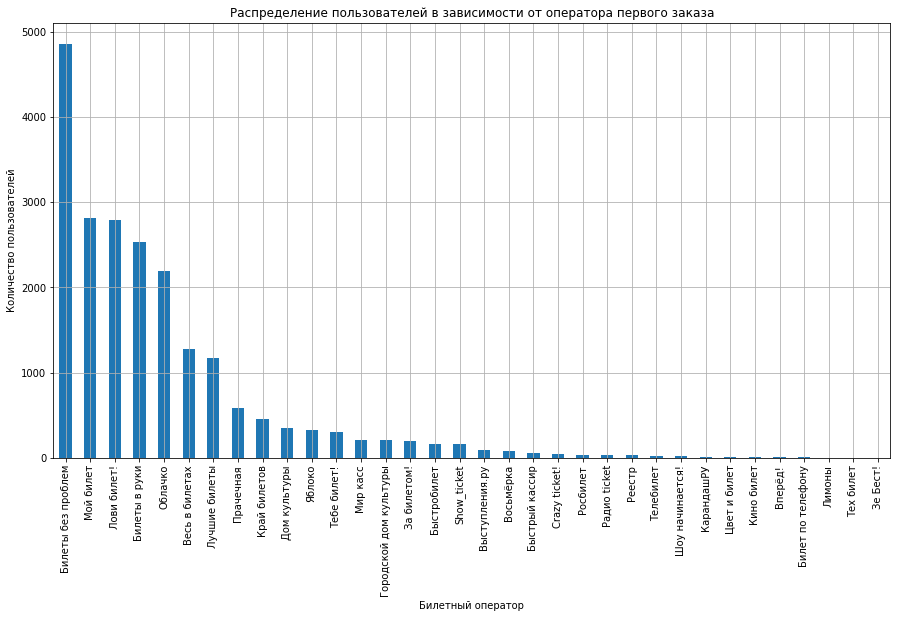

In [50]:
#по билетному оператору, продавшему билеты на первый заказ

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 8))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
df['service_name'].value_counts().plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               #rot=45, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение пользователей в зависимости от оператора первого заказа'
)

# Настраиваем оформление графика
plt.xlabel('Билетный оператор')
plt.ylabel('Количество пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Посчитали доли пользователей по сегментам:

- По типу их первого мероприятия:
  - Наибольший сегмент - концерты (доля составляет 0.44)
  - наименьшее число людей в сегменте ёлки (доля 0.004)
- По типу устройства, с которого совершена первая покупка:
  - Наибольший сегмент - мобильные устройства (доля составляет 0.83)
  - наименьшее число людей в сегменте desktop (доля 0.17)
- По региону проведения мероприятия из первого заказа:
  - Наибольший сегмент - Каменевский регион (доля составляет 0.33)
  - наименьшее число людей в сегменте Яснопольский округ (доля 0.000047 (1 пользователь))
- По билетному оператору, продавшему билеты на первый заказ:
  - Наибольший сегмент - Билеты без проблем (доля составляет 0.23)
  - наименьшее число людей в сегменте Зе Бест! (доля 0.000047 (1 пользователь))

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [51]:
#по типу их первого мероприятия
event_type_two_rate = df.groupby('event_type')['is_two'].mean().sort_values(ascending=False)
print(event_type_two_rate)

event_type
выставки    0.642686
театр       0.635142
концерты    0.618174
стендап     0.608893
другое      0.594347
спорт       0.547368
ёлки        0.541667
Name: is_two, dtype: float64


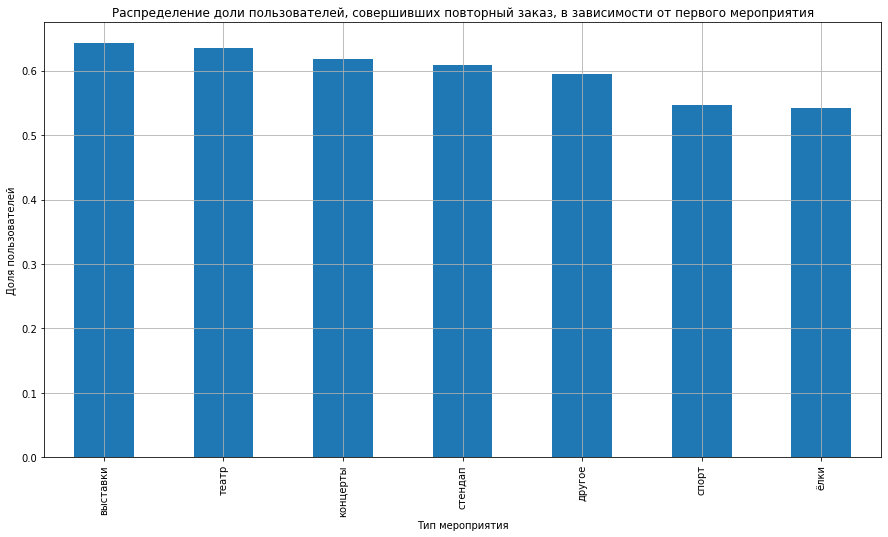

In [52]:
#по типу их первого мероприятия

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 8))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
event_type_two_rate.plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               #y='is_two',
               legend=False, # Выключаем легенду
               title=f'Распределение доли пользователей, совершивших повторный заказ, в зависимости от первого мероприятия'
)

# Настраиваем оформление графика
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Среди пользователей, разбитых по сегментам в зависимости от типа их первого мероприятия, чаще возвращаются на Яндекс Афишу по сегменту "выставки", реже всего "ёлки". Это может быть связано с тем, что ёлки популярны только в период новогодних праздников

In [53]:
#по типу устройства, с которого совершена первая покупка;
device_two_rate = df.groupby('device')['is_two'].mean().sort_values(ascending=False)
print(device_two_rate)

device
desktop    0.636263
mobile     0.608103
Name: is_two, dtype: float64


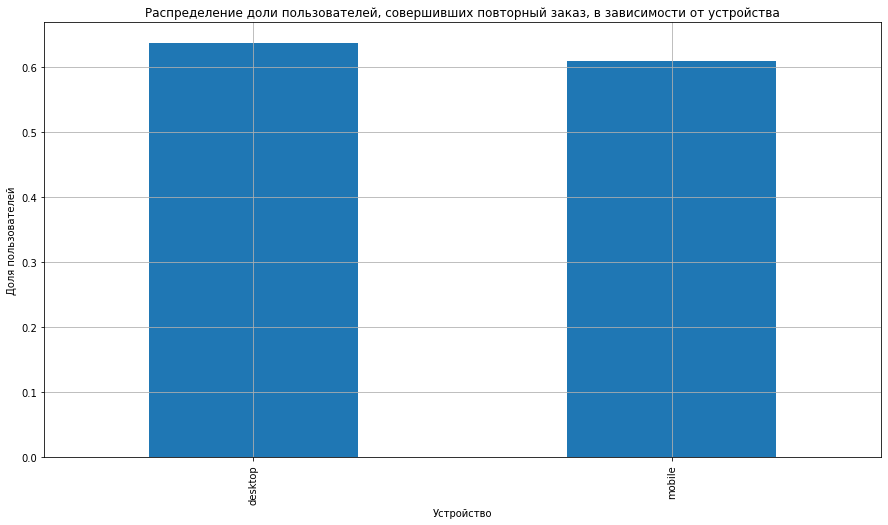

In [54]:
#по типу устройства, с которого совершена первая покупка;

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 8))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
device_two_rate.plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               #y='is_two',
               legend=False, # Выключаем легенду
               title=f'Распределение доли пользователей, совершивших повторный заказ, в зависимости от устройства'
)

# Настраиваем оформление графика
plt.xlabel('Устройство')
plt.ylabel('Доля пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Среди пользователей, разбитых по сегментам в зависимости от типа устройства, чаще возвращаются на Яндекс Афишу, сделавшие заказ на ПК

In [55]:
#по региону проведения мероприятия из первого заказа;
region_two_rate = df.groupby('region')['is_two'].mean().sort_values(ascending=False)
print(region_two_rate)

region
Верхозёрский край           1.000000
Озернопольская область      0.896552
Радужнопольский край        0.791667
Шанырский регион            0.765244
Горноземский регион         0.714286
                              ...   
Крутоводский регион         0.333333
Теплоозёрский округ         0.333333
Сосноводолинская область    0.000000
Островогорский округ        0.000000
Яснопольский округ          0.000000
Name: is_two, Length: 81, dtype: float64


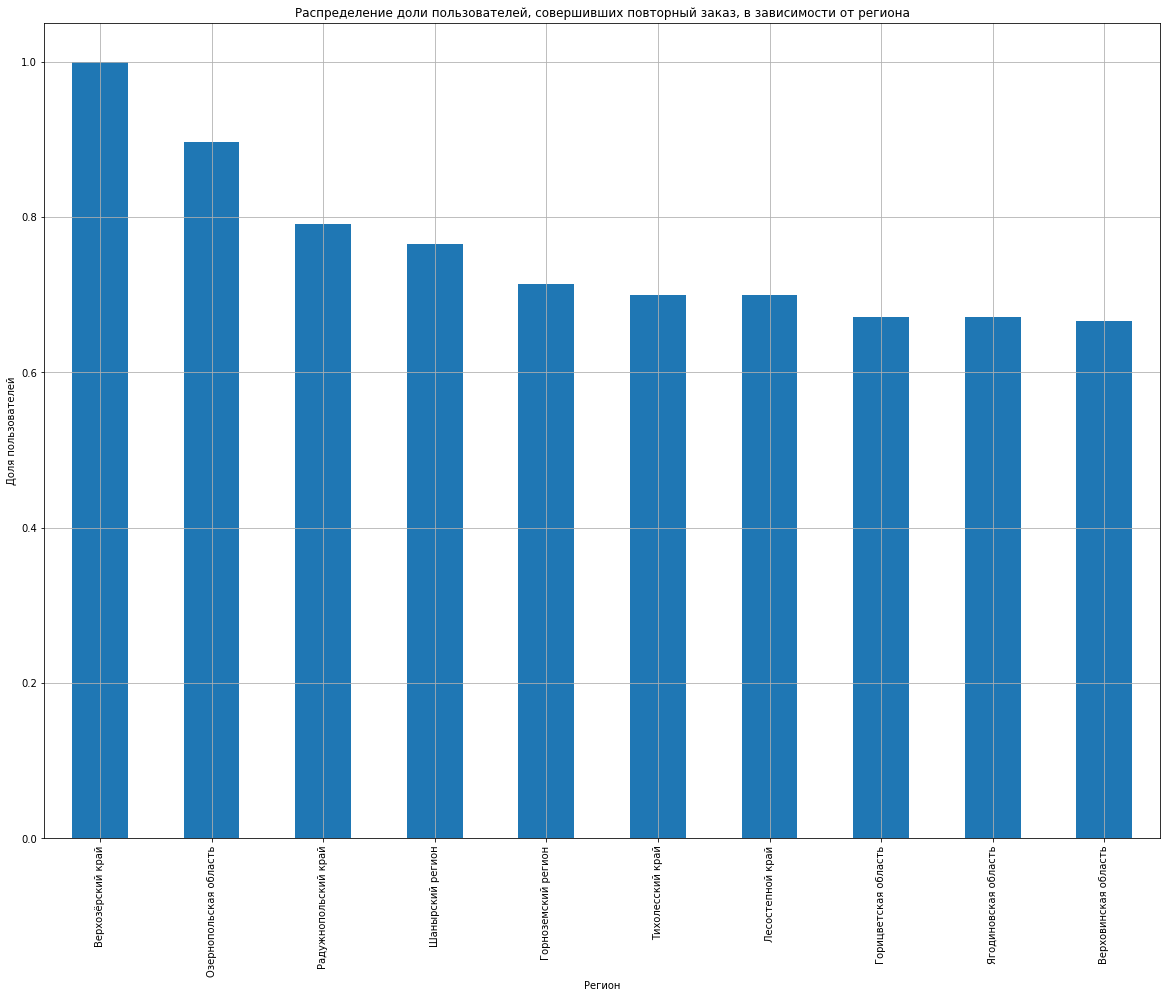

In [56]:
#по региону проведения мероприятия из первого заказа;

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(20, 15))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
region_two_rate.head(10).plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               #y='is_two',
               legend=False, # Выключаем легенду
               title=f'Распределение доли пользователей, совершивших повторный заказ, в зависимости от региона'
)

# Настраиваем оформление графика
plt.xlabel('Регион')
plt.ylabel('Доля пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Среди пользователей, разбитых по сегментам в зависимости от региона проведения мероприятия, чаще возвращаются на Яндекс Афишу, сделавшие заказ в регионе Верхозёрский край. Среди регионов Сосноводолинская область, Островогорский округ, Яснопольский округ - возвратов нет совсем.
Однако выше в анализе мы заметили, что в Яснопольском округе, Сосноводолинская область и Верхозёрский край всего один пользователь совершал заказы, что является маленькой выборкой. После этого делаем вывод, что чаще возвращаются пользователи с Озернопольской области

In [57]:
#по билетному оператору, продавшему билеты на первый заказ.
service_name_two_rate = df.groupby('service_name')['is_two'].mean().sort_values(ascending=False)
print(service_name_two_rate)

service_name
Зе Бест!                  1.000000
Быстрый кассир            0.850000
Реестр                    0.812500
Crazy ticket!             0.688889
Восьмёрка                 0.670588
Билет по телефону         0.666667
Цвет и билет              0.666667
Росбилет                  0.650000
Show_ticket               0.650000
Дом культуры              0.648725
Край билетов              0.648590
Мир касс                  0.639810
Прачечная                 0.630324
Билеты в руки             0.626777
Весь в билетах            0.624608
Лучшие билеты             0.617221
Облачко                   0.613109
Тебе билет!               0.611650
Лови билет!               0.611310
Выступления.ру            0.610526
Мой билет                 0.608726
Быстробилет               0.604938
Билеты без проблем        0.599629
За билетом!               0.595000
Городской дом культуры    0.585714
Вперёд!                   0.571429
Кино билет                0.555556
Яблоко                    0.534161
Лимоны 

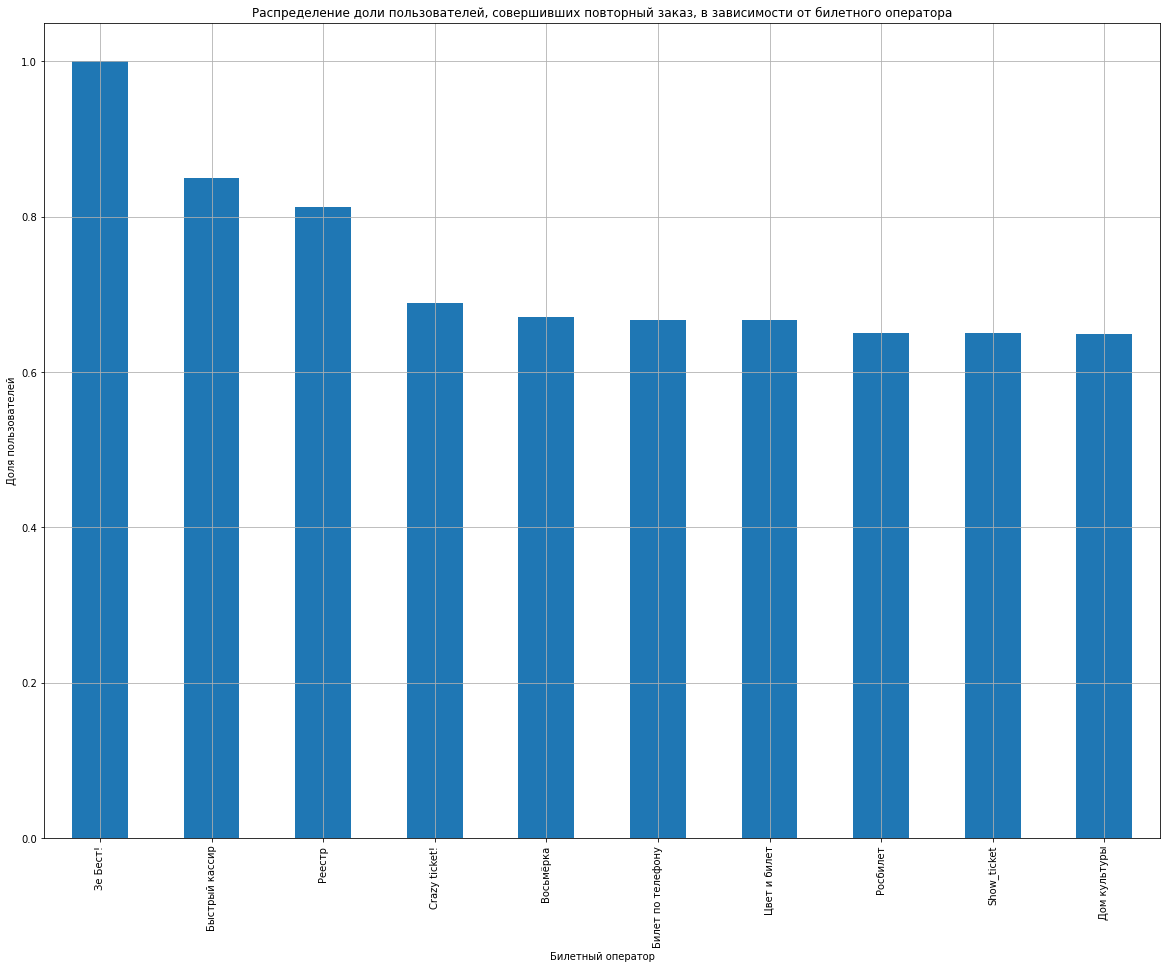

In [58]:
#по билетному оператору, продавшему билеты на первый заказ.

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(20, 15))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
service_name_two_rate.head(10).plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               #y='is_two',
               legend=False, # Выключаем легенду
               title=f'Распределение доли пользователей, совершивших повторный заказ, в зависимости от билетного оператора'
)

# Настраиваем оформление графика
plt.xlabel('Билетный оператор')
plt.ylabel('Доля пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Среди пользователей, разбитых по сегментам в зависимости от билетного оператора, чаще возвращаются на Яндекс Афишу, сделавшие заказ в Зу Бест!. Меньше всего возвратов - Шоу начинается!
Однако выше в анализе мы заметили, что билетным оператором Зе Бест! пользуется один пользователь, что является маленькой выборкой для анализа. Соответственно, чаще всего возвращаются пользователи, которые пользуются билетным оператором Быстрый кассир

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Гипотеза 1 - нет, так как пользователи, оформившие свой первый заказ на концерты совершают повторный заказ чаще, чем пользователи, купившие билет на спортивные мероприятия
При этом наиболее высокая вероятность возврата из всех категорий у пользователей, которые ходят на выставки

Гипотеза 2 - нет, скорее даже наоборот. В регионах, где больше всего повторных заказов - меньше посещений мероприятий. Возможно, это связано с численностью населения региона (меньше людей - меньше посещений мероприятий). В анализе выше мы уже отмечали, что билетным оператором Зе Бест! пользуется один пользователь. К тому же в низконаселенных регионах может быть меньше мероприятий. Для этого нужно проводить дополнительный анализ 

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


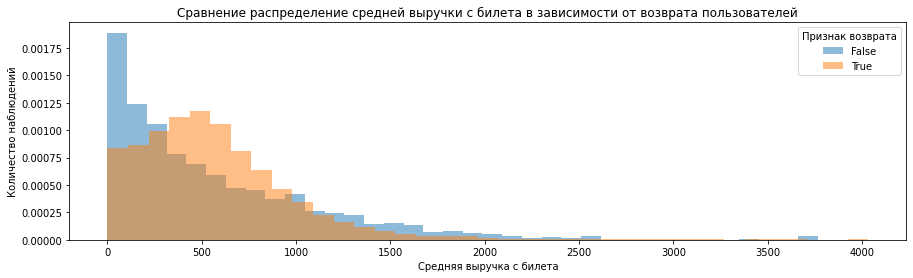

In [59]:
# Строим гистограмму распределения значений средней выручки
# Создаём фигуру графика
plt.figure(figsize=(15, 4))

# Строим гистограммы для каждого значения is_two
for i in df['is_two'].unique():
    # Фильтруем данные по значению столбца is_two
    df.loc[df['is_two'] == i, 'revenue_avg'].plot(
        kind='hist',
        bins=37,
        alpha=0.5,
        label=f'{i}',
        legend=True,
        density = True
    )

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Сравнение распределение средней выручки с билета в зависимости от возврата пользователей')
plt.xlabel('Средняя выручка с билета')
plt.ylabel('Количество наблюдений')
plt.legend(title='Признак возврата')
plt.show()

Можно заметить, что распределение выборки с признаком повторного заказа = True смещено в область более высоких значений. При этом частота выше у значений с признаком False

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


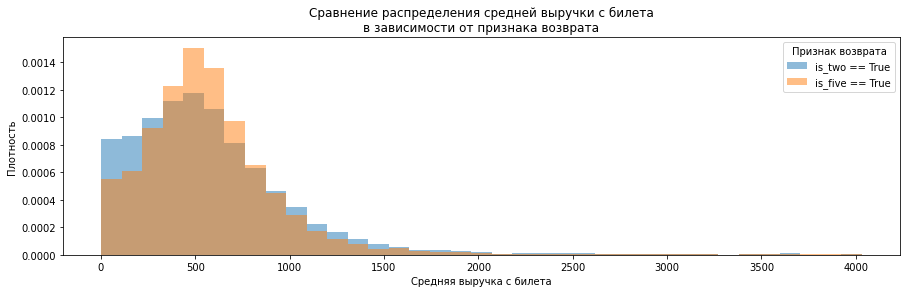

In [60]:
# Строим гистограмму распределения значений средней выручки
# Фильтруем данные для каждой группы
data_is_two = df[df['is_two'] == True]['revenue_avg']
data_is_five = df[df['is_five'] == True]['revenue_avg']

# Создаём фигуру графика
plt.figure(figsize=(15, 4))

# Строим гистограмму для is_two == True
plt.hist(data_is_two, bins=37, alpha=0.5, label='is_two == True', density=True)

# Строим гистограмму для is_five == True
plt.hist(data_is_five, bins=37, alpha=0.5, label='is_five == True', density=True)

# Настраиваем внешний вид и подписи
plt.title('Сравнение распределения средней выручки с билета\nв зависимости от признака возврата')
plt.xlabel('Средняя выручка с билета')
plt.ylabel('Плотность')
plt.legend(title='Признак возврата')

# Отображение графика
plt.show()

Различия есть по значению средней выручки с заказа между пользователями этих двух групп (группы с повторным заказов и группы с заказами более 5). Люди, которые возвращаются 5 раз и более имеют бОльшую частату заказов в диапазоне около 400-700

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [61]:
#проведем сегментацию и запишем результат в новый столбец
def add_segment(df):
    if df['tickets_count_avg'] >= 1 and df['tickets_count_avg'] < 2:
        return 'от 1 до 2 билетов'
    if df['tickets_count_avg'] >= 2 and df['tickets_count_avg'] < 3:
        return 'от 2 до 3 билетов'
    if df['tickets_count_avg'] >= 3 and df['tickets_count_avg'] < 5:
        return 'от 3 до 5 билетов'
    if df['tickets_count_avg'] >= 5:
        return 'от 5 и более билетов'


df['segment'] = df.apply(add_segment, axis = 1)
#print(df.head)

In [62]:
# Получаем количество повторных заказов по сегментам
df_segment = df[df['is_two']].groupby('segment')['user_id'].count().reset_index()

# Получаем общее количество пользователей по сегментам
total_counts = df.groupby('segment')['user_id'].count().reset_index()

# Объединяем по сегментам
df_segment = df_segment.merge(total_counts, on='segment')

# Вычисляем долю
df_segment['rate'] = df_segment['user_id_x'] / df_segment['user_id_y']

print(df_segment)

#on=['order_id', 'product_id']

                segment  user_id_x  user_id_y      rate
0     от 1 до 2 билетов       1240       2408  0.514950
1     от 2 до 3 билетов       7062       9560  0.738703
2     от 3 до 5 билетов       4605       8691  0.529858
3  от 5 и более билетов         38        462  0.082251


<Figure size 1440x1080 with 0 Axes>

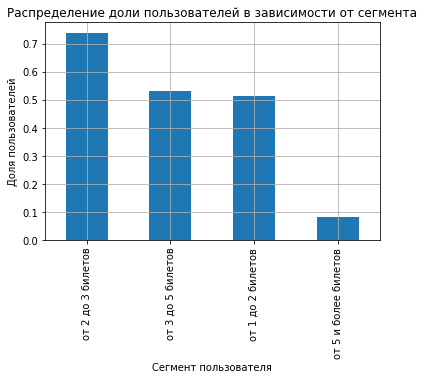

In [63]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(20, 15))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
df_segment.sort_values(by='rate', ascending=False).plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               x='segment',
               y='rate',
               legend=False, # Выключаем легенду
               title=f'Распределение доли пользователей в зависимости от сегмента'
)

# Настраиваем оформление графика
plt.xlabel('Сегмент пользователя')
plt.ylabel('Доля пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Разделили пользователей на несколько сегментов по среднему количеству билетов в заказе. Наибольшую долю занимает сегмент пользователей, совершивших от 2 до 3 заказов, а меньшую - от 5 и более

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [64]:
df['day_of_week'] = df['first_date'].dt.day_of_week

In [65]:
df_days = df.groupby('day_of_week')['user_id'].count().sort_values(ascending = False).reset_index()
df_days['rate'] = df_days['user_id'] / df_days['user_id'].sum()

In [66]:
# Получаем количество повторных заказов по сегментам
df_days = df[df['is_two']].groupby('day_of_week')['user_id'].count().reset_index()

# Получаем общее количество пользователей по сегментам
total_counts = df.groupby('day_of_week')['user_id'].count().reset_index()

# Объединяем по сегментам
df_days = df_days.merge(total_counts, on='day_of_week')

# Вычисляем долю
df_days['rate'] = df_days['user_id_x'] / df_days['user_id_y']

print(df_days)

#on=['order_id', 'product_id']

   day_of_week  user_id_x  user_id_y      rate
0            0       1769       2834  0.624206
1            1       1891       3063  0.617369
2            2       1876       3014  0.622429
3            3       1827       3057  0.597645
4            4       1904       3184  0.597990
5            5       2040       3251  0.627499
6            6       1638       2718  0.602649


<Figure size 1440x1080 with 0 Axes>

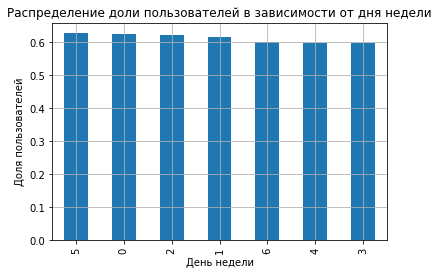

In [67]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(20, 15))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
df_days.sort_values(by='rate', ascending=False).plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               x='day_of_week',
               y='rate',
               legend=False, # Выключаем легенду
               title=f'Распределение доли пользователей в зависимости от дня недели'
)

# Настраиваем оформление графика
plt.xlabel('День недели')
plt.ylabel('Доля пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

День недели, в которую совершена первая покупка, влияет на вероятность возврата клиента
- Больше всего - в субботу, 
- меньше всего - в пятницу

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [68]:
#считает лайфтайм
df['lifetime'] = df['last_date'] - df['first_date']
df['lifetime'] = df['lifetime'].dt.days


In [69]:
#отфильтруем пользователей, чтобы в группу is_two не попадали пользователи, совершившие более 5 заказов
df_lifetime_two = df[(df['is_two'] == True) & (df['is_five'] == False)]['lifetime'].mean()
df_lifetime_five = df[df['is_five'] == True]['lifetime'].mean()
print(df_lifetime_five)
print(df_lifetime_two)

95.36866823213687
33.67091507947873


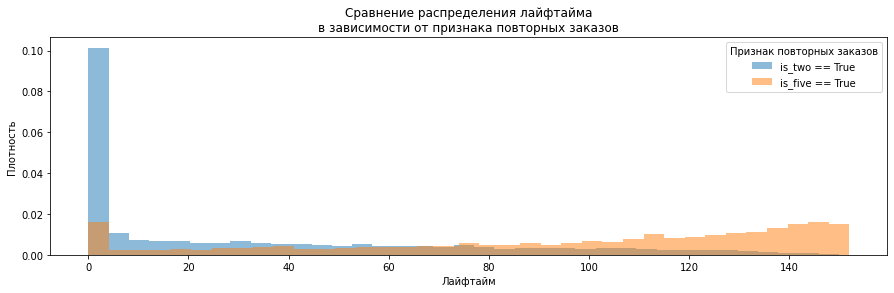

In [70]:
# Строим гистограмму распределения значений лайфтайма
# Фильтруем данные для каждой группы
lifetime_is_two = df[(df['is_two'] == True) & (df['is_five'] == False)]['lifetime']
lifetime_is_five = df[df['is_five'] == True]['lifetime']

# Создаём фигуру графика
plt.figure(figsize=(15, 4))

# Строим гистограмму для is_two == True
plt.hist(lifetime_is_two, bins=37, alpha=0.5, label='is_two == True', density=True)

# Строим гистограмму для is_five == True
plt.hist(lifetime_is_five, bins=37, alpha=0.5, label='is_five == True', density=True)

# Настраиваем внешний вид и подписи
plt.title('Сравнение распределения лайфтайма\nв зависимости от признака повторных заказов')
plt.xlabel('Лайфтайм')
plt.ylabel('Плотность')
plt.legend(title='Признак повторных заказов')

# Отображение графика
plt.show()

Вывод - среднее время между первым и последним заказом пользователей больше среди тех, кто совершал более 5 заказов. Повторные заказы чаще совершаются при лайфтайме от 0 до 10

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [71]:
# Вычисляем корреляционную матрицу с использованием phi_k
correlation_matrix = df[['device', 'region', 'service_name', 'event_type', 'orders_count', 'revenue_avg', 'tickets_count_avg', 'days_since_prev_avg', 'is_five', 'is_two', 'segment', 'day_of_week', 'lifetime']].phik_matrix()


interval columns not set, guessing: ['orders_count', 'revenue_avg', 'tickets_count_avg', 'days_since_prev_avg', 'day_of_week', 'lifetime']


In [72]:
#проверим корреляцию для total_orders
correlation_matrix.loc[correlation_matrix.index != 'orders_count'][['orders_count']].sort_values(by='orders_count', ascending=False)

,orders_count
is_five,0.636616
lifetime,0.621865
tickets_count_avg,0.394942
is_two,0.320043
days_since_prev_avg,0.295669
segment,0.219219
revenue_avg,0.208449
region,0.131659
day_of_week,0.053178
event_type,0.025362


В большинстве полей значения близки к 0, что говорит об отсутствии корреляции. Однако коэффициент корреляции показывает значение 0,62 с полями lifetime и с признаком заказов более пяти (is_five)

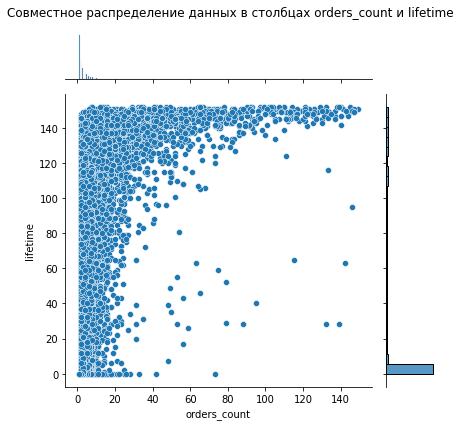

In [73]:
# Построим график совместного распределения для столбцов `orders_count` и `lifetime`
sns.jointplot(data=df, x='orders_count', y='lifetime')

# Подписываем и отображаем график
plt.suptitle('Совместное распределение данных в столбцах orders_count и lifetime')
plt.tight_layout()
plt.show()

График показывает сильную связь количества заказов с лайфтаймом

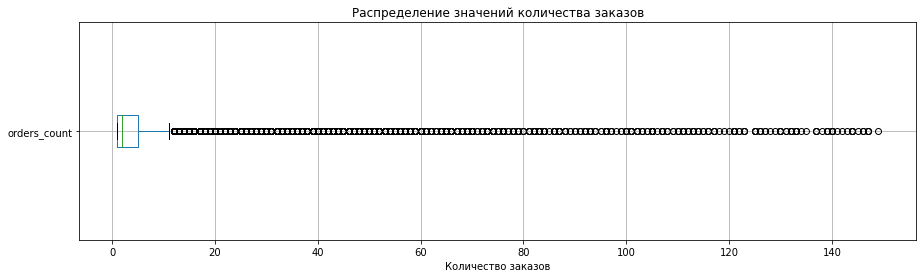

In [74]:
#проверим разброс
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 4))

# Строим диаграмму размаха значений в столбце orders_count
df.boxplot(column='orders_count', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение значений количества заказов')
plt.xlabel('Количество заказов')

# Выводим график
plt.show()

In [75]:
print(df['orders_count'].describe(percentiles=[0.99]))
print(df['orders_count'].mode())

count    21121.000000
mean         6.396383
std         13.914388
min          1.000000
50%          2.000000
99%         77.000000
max        149.000000
Name: orders_count, dtype: float64
0    1
dtype: int64


Столбец orders_count ранее уже отфильтровывали по 99 процентилю. Мода = 1. 

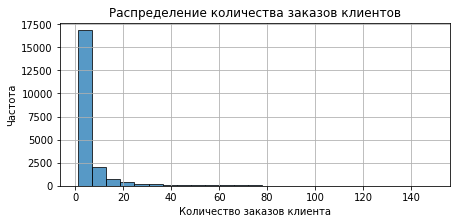

In [76]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим гистограмму с помощью pandas через plot(kind='hist')
df['orders_count'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=25, # Устанавливаем количество корзин - всего 25
                alpha=0.75,
                edgecolor='black',
                rot=0, # Градус вращения подписи по оси Х
)

# Настраиваем оформление графика
plt.title('Распределение количества заказов клиентов')
plt.xlabel('Количество заказов клиента')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

In [77]:
#проведем сегментацию и запишем результат в новый столбец
def add_segment_total_orders(df):
    if df['orders_count'] == 1:
        return '1 заказ'
    if df['orders_count'] >= 2 and df['orders_count'] <= 4:
        return 'от 2 до 4 заказов'
    if df['orders_count'] >= 5:
        return 'от 5 и выше'

df['segment_total_orders'] = df.apply(add_segment_total_orders, axis = 1)

In [78]:
# Вычисляем корреляционную матрицу с использованием phi_k
correlation_matrix = df[['device', 'region', 'service_name', 'event_type', 'orders_count', 'revenue_avg', 'tickets_count_avg', 'days_since_prev_avg', 'is_five', 'is_two', 'segment', 'day_of_week', 'lifetime', 'segment_total_orders']].phik_matrix()


interval columns not set, guessing: ['orders_count', 'revenue_avg', 'tickets_count_avg', 'days_since_prev_avg', 'day_of_week', 'lifetime']


In [79]:
correlation_matrix.loc[correlation_matrix.index != 'segment_total_orders'][['segment_total_orders']].sort_values(by='segment_total_orders', ascending=False)

,segment_total_orders
is_five,1.000000
is_two,1.000000
lifetime,0.728458
tickets_count_avg,0.658367
orders_count,0.502146
days_since_prev_avg,0.394709
revenue_avg,0.285639
segment,0.242147
region,0.144778
service_name,0.078112


- Так как сегмент вычислялся на основе количества заказов, то матрица корреляции отражает прямую зависимость с полями is_five и is_two, что логично.
- Снова видим связь количества заказов с lifetime (коэффициент корреляции = 0,73)

Проверим корреляцию по каждому сегменту отдельно, кроме сегмента "1 заказ", так как по нему корреляцию посчитать не получится, потому что orders_count = 1

In [80]:
#отбираем сегмент от 5 и выше
segments_5 = df[df['segment_total_orders'] == 'от 5 и выше']


#вычисляем корреляционную матрицу для каждого сегмента
correlation_matrix_ord_5 = segments_5[['device', 'region', 'service_name', 'event_type', 'orders_count', 'revenue_avg', 'tickets_count_avg', 'days_since_prev_avg', 'segment', 'day_of_week', 'lifetime']].phik_matrix()

correlation_matrix_ord_5.loc[correlation_matrix_ord_5.index != 'orders_count'][['orders_count']].sort_values(by='orders_count', ascending=False)


interval columns not set, guessing: ['orders_count', 'revenue_avg', 'tickets_count_avg', 'days_since_prev_avg', 'day_of_week', 'lifetime']


,orders_count
days_since_prev_avg,0.687613
lifetime,0.556962
tickets_count_avg,0.285574
segment,0.254058
region,0.178426
revenue_avg,0.172741
day_of_week,0.092983
event_type,0.046936
device,0.000000
service_name,0.000000


В сегменте "от 5 и выше" видим сильную корреляцию количества заказов с параметров days_since_prev_avg	(количество дней от предыдущей покупки пользователя) и умеренную корреляцию с параметром лайфтайм

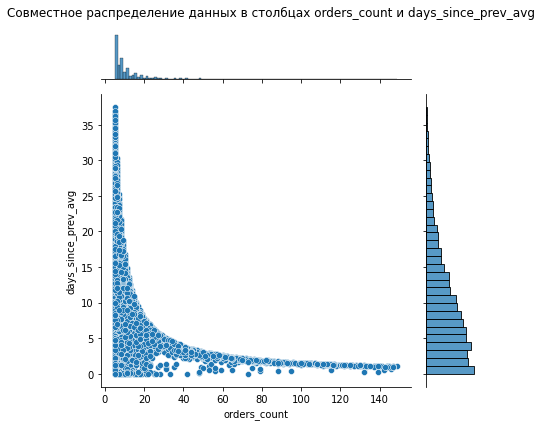

In [81]:
# Построим график совместного распределения для столбцов `orders_count` и `lifetime`
sns.jointplot(data=df[df['segment_total_orders'] == 'от 5 и выше'], x='orders_count', y='days_since_prev_avg')

# Подписываем и отображаем график
plt.suptitle('Совместное распределение данных в столбцах orders_count и days_since_prev_avg')
plt.tight_layout()
plt.show()

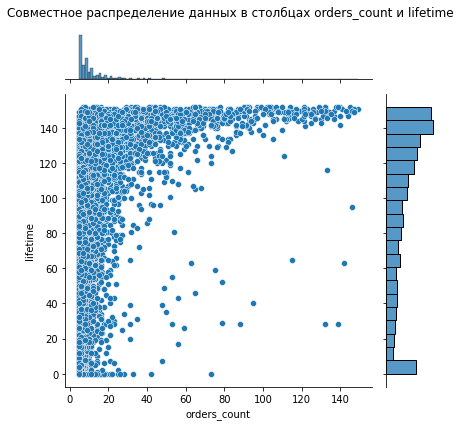

In [82]:
# Построим график совместного распределения для столбцов `orders_count` и `lifetime`
sns.jointplot(data=df[df['segment_total_orders'] == 'от 5 и выше'], x='orders_count', y='lifetime')

# Подписываем и отображаем график
plt.suptitle('Совместное распределение данных в столбцах orders_count и lifetime')
plt.tight_layout()
plt.show()

In [83]:
#отбираем сегмент от 2 до 4
segments_2 = df[df['segment_total_orders'] == 'от 2 до 4 заказов']


#вычисляем корреляционную матрицу для каждого сегмента
correlation_matrix_ord_2 = segments_2[['device', 'region', 'service_name', 'event_type', 'orders_count', 'revenue_avg', 'tickets_count_avg', 'days_since_prev_avg', 'segment', 'day_of_week', 'lifetime']].phik_matrix()

correlation_matrix_ord_2.loc[correlation_matrix_ord_2.index != 'orders_count'][['orders_count']].sort_values(by='orders_count', ascending=False)


interval columns not set, guessing: ['orders_count', 'revenue_avg', 'tickets_count_avg', 'days_since_prev_avg', 'day_of_week', 'lifetime']


,orders_count
tickets_count_avg,0.394811
days_since_prev_avg,0.375290
lifetime,0.287294
revenue_avg,0.091745
segment,0.082102
service_name,0.053572
device,0.007467
region,0.000000
event_type,0.000000
day_of_week,0.000000


В сегменте "от 2 до 4 заказов" видим умеренную корреляцию с параметрами tickets_count_avg и days_since_prev_avg	

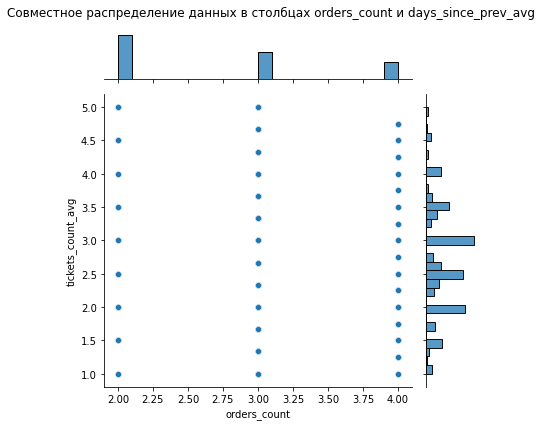

In [84]:
# Построим график совместного распределения для столбцов `orders_count` и `lifetime`
sns.jointplot(data=df[df['segment_total_orders'] == 'от 2 до 4 заказов'], x='orders_count', y='tickets_count_avg')

# Подписываем и отображаем график
plt.suptitle('Совместное распределение данных в столбцах orders_count и days_since_prev_avg')
plt.tight_layout()
plt.show()

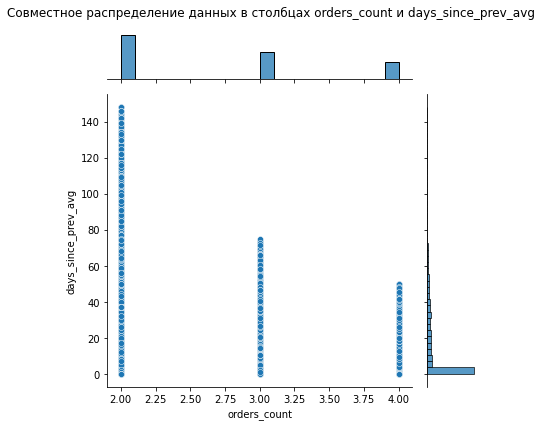

In [85]:
# Построим график совместного распределения для столбцов `orders_count` и `lifetime`
sns.jointplot(data=df[df['segment_total_orders'] == 'от 2 до 4 заказов'], x='orders_count', y='days_since_prev_avg')

# Подписываем и отображаем график
plt.suptitle('Совместное распределение данных в столбцах orders_count и days_since_prev_avg')
plt.tight_layout()
plt.show()

В результате коррелияции по сегментам:
- В сегменте "от 5 и выше" видим сильную связь количества заказов с параметров days_since_prev_avg (количество дней от предыдущей покупки пользователя) и умеренную связь с параметром лайфтайм. Эти данные также подтверждаются графиками совместного распределения
- В сегменте "от 2 до 4 заказов" видим умеренную связь с параметрами tickets_count_avg и days_since_prev_avg. На графиках корреляция незаметна

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Информация о данных**
- Датасет clients_df содержит 15 столбцов и 290611 строк, в которых представлена информация о клиентах Яндекс Афиши. В результате предобработки данных были выполнены следующие действия:
  - Сумма заказов приведена к единой валюте - был добавлен столбец revenue_rub, который отражает сумму в рублях
  - Проведена проверка на явные дубликаты - они не обнаружены
  - Понижена размерность числовых столбцов
  - Проведена проверка на уникальные значения в столбцах с номинальными данными
  - Отфильтрованы значения по столбцу revenue_rub - удалены 3007 строк, что составляет 1.03%

**Основные результаты анализа.** 

Построили профиль пользователя - создан новый датафрейм df для дальнейшней работы
По профилю посчитали статистические показатели:
- общее число пользователей (21121), средняя выручкв с одного заказа (574.84), доля пользователей, совершивших 2 и более заказа 61.29%%), доля пользователей, совершивших 5 и более заказов 28.23%)

Отфильтровали выбросы по 99 процентилю в столбце orders_count, в результате чего удалили 216 строк
Отфильтровали выбросы по 99 процентилю в столбце revenue_rub. Удалили 214 строк

Посчитали доли пользователей по сегментам:

- По типу их первого мероприятия:
  - Наибольший сегмент - концерты (доля составляет 0.44)
  - наименьшее число людей в сегменте ёлки (доля 0.004)
- По типу устройства, с которого совершена первая покупка:
  - Наибольший сегмент - мобильные устройства (доля составляет 0.83)
  - наименьшее число людей в сегменте desktop (доля 0.17)
- По региону проведения мероприятия из первого заказа:
  - Наибольший сегмент - Каменевский регион (доля составляет 0.33)
  - наименьшее число людей в сегменте Яснопольский округ (доля 0.000047 (1 пользователь))
- По билетному оператору, продавшему билеты на первый заказ:
  - Наибольший сегмент - Билеты без проблем (доля составляет 0.23)
  - наименьшее число людей в сегменте Зе Бест! (доля 0.000047 (1 пользователь))
 
 
Опровергли две гипотезы (Гипотеза 1. Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
Гипотеза 2. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.)
 - Выяснили, что пользователи, оформившие свой первый заказ на концерты совершают повторный заказ чаще, чем пользователи, купившие билет на спортивные мероприятия. При этом наиболее высокая вероятность возврата из всех категорий у пользователей, которые ходят на выставки
 - В регионах, где больше всего повторных заказов - меньше посещений мероприятий. Возможно, это связано с численностью населения региона (меньше людей - меньше посещений мероприятий). В анализе выше мы уже отмечали, что билетным оператором Зе Бест! пользуется один пользователь. К тому же в низконаселенных регионах может быть меньше мероприятий. Для этого нужно проводить дополнительный анализ
 
 
Заметили, что выручка с билета пользователей с признаком повторного заказа больше, чем у пользователей, совершивших один заказ. Однако, чаще совершаются транзакции на меньшие суммы у пользователей, совершающих повторные заказы. А люди, которые возвращаются 5 раз и более имеют бОльшую частоту заказов в диапазоне около 800-1000


Далее разделили пользователей на несколько сегментов по среднему количеству билетов в заказе:
 - Наибольшую долю занимает сегмент пользователей, совершивших от 2 до 3 заказов, а меньшую - от 5 и более

День недели, в которую совершена первая покупка, влияет на вероятность возврата клиента
- Больше всего - в субботу, 
- меньше всего - в пятницу
 
 
Среднее время между первым и последним заказом пользователей больше среди тех, кто совершал более 5 заказов. Повторные заказы чаще совершаются при лайфтайме от 0 до 10

Высокий коэффициент корреляции показывает высокую зависимость количества заказов с полем lifetime. То есть чем больше времени проходит, тем выше вероятность повторного заказа

В результате коррелияции по сегментам:
- В сегменте "от 5 и выше" видим сильную связь количества заказов с параметров days_since_prev_avg (количество дней от предыдущей покупки пользователя)и умеренную связь с параметром лайфтайм. Эти данные также подтверждаются графиками совместного распределения
- В сегменте "от 2 до 4 заказов" видим умеренную связь с параметрами tickets_count_avg и days_since_prev_avg. На графиках корреляция незаметна

**Рекомендации.** 

1. Стоит провести дополнительный анализ мероприятий в регионах с меньшей посещаемостью мероприятий, но при этом с высоким возвратом. Возможно там есть билетные операторы, не представленные в Яндекс афише и при установлении сотрудничества с ними - удастся продавать больше билетов в таких регионах. Однако также может оказаться, что регион с низкой численностью населения, либо с маленьким количеством мероприятий.

2. Так как повторные заказы чаще совершаются при лайфтайме от 0 до 10 дней, стоит обратить внимание на пользователей не совершивших повторный заказ за это время и предложить ему скидку на 11ый день от первой покупки. Также это коррелируется с выводом о том, что чем больше лайфтайм, тем выше вероятность повторного заказа - это поможет сократить время до повторного заказа. Также было отмечено, что чем ниже сумма, тем выше вероятность повторной покупки

3. Стоит обратить внимание на сегменты:
 -  Так как в сегменте по типу первого мероприятия пользователя преобладают концерты, то стоит обратить внимание на остальные мероприятия и давать скидку на первый заказ в этих категориях
 -  Также необходимо дополнительно провести анализ по билетным операторам. 

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.


**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**

https://github.com/JuliaOrekhova/yandex_afisha.git